#  Master's Thesis - Optimization model - Catarina Almeida - 20Y Analysis with Linear Degradation - WITHOUT RENEWABLES

## Base-case Scenario

### Import Libraries

In [1]:
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import openpyxl
import gurobipy_pandas as gppd
print(gp.gurobi.version())

(10, 0, 1)


### 1. Create new model

In [2]:
m=gp.Model('MIP1')

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2366648
Academic license - for non-commercial use only - registered to catarina.isabel.novais.da.luz@estudiantat.upc.edu


### 2. Variables and Constants

In [3]:
### Constants

# CHANGE NUMBER OF YEARS HERE
years = 20


## hours in an year

gra = np.arange(0, 100, 1)
n = np.arange(0, 8760*years, 1)
M=10e6

###
# Read the Excel file with a specific sheet
df_down = pd.read_excel('prices_FCR_D.xlsx', sheet_name='FCR-D_down')
df_up = pd.read_excel('prices_FCR_D.xlsx', sheet_name='FCR-D_up')
df_DA = pd.read_excel('prices_FCR_D.xlsx', sheet_name='Day-ahead')

# Create an empty array to store the combined values
combined_array_down = np.empty((0,))
combined_array_up = np.empty((0,))
combined_array_DA = np.empty((0,))

## DA, FCR-D up and down prices from D-2 in 2022
for year_column in df_down.columns[:years]:
    year_values_down = df_down[year_column].values
    combined_array_down = np.concatenate((combined_array_down, year_values_down))
    
    year_values_up = df_up[year_column].values
    combined_array_up = np.concatenate((combined_array_up, year_values_up))
    
    year_values_DA = df_DA[year_column].values
    combined_array_DA = np.concatenate((combined_array_DA, year_values_DA))

down_prices = combined_array_down
up_prices = combined_array_up
SM_prices_sell = combined_array_DA*0.75
SM_prices_pur = combined_array_DA*1.25

## solar and wind availability 
df_av = pd.read_excel('Availability.xlsx') 
PV_av = df_av['PV KW/KWcap']
PV_av=PV_av.astype(float)
PV_av = pd.concat([PV_av] * 20, axis=0, ignore_index=True)
wind_av = df_av['Wind KW/KWcap']
wind_av = pd.concat([wind_av] * 20, axis=0, ignore_index=True)

## system size

EL_cap = 3 #MW
comp_cap = 0.075 #MW
tank_cap = 20 #MWhlvh
FC_cap = 0.650 # MW

## costs
# CAPEX

EL_capex = 1352 #kEUR/MW
comp_capex = 1600 #kEUR/MW
tank_capex = 15 #kEUR/MWh
FC_capex = 3000 #kEUR/MW

# OPEX

EL_opex = 0.01 #%CAPEX
comp_opex = 0.01 #%CAPEX
tank_opex = 0.025 #%CAPEX
FC_opex = 0.02 #%CAPEX

# REPEX
EL_repex = 0.40 # % CAPEX
FC_repex = 0.21 # % CAPEX





## Technical specifications 
EL_eff = 0.70 # EL efficiency [%]
FC_eff = 0.50 #FC efficiency [%]
wcomp = 3.8 # MJ/KgH2 compressor consumption 
LHVh2 = 120 # MJ/Kg LHV of H2
etank = 0.00 # self-discahrge of the tank
eEL = 0.010 # minimum load of EL
eFC = 0.010 # minimum load of FC
cfEL = 0.9 # capacity factor EL
cfFC = 0.9 # capacity factor FC
ltEL= 40000 # lifetime electrolyzer [h]
ltFC= 25000 # lifetime fuel cell [h]

## Index
i = pd.RangeIndex(8760*years, name ="i")


        
Inv_costs = (FC_capex*FC_cap*(1+FC_opex)+7*FC_repex*FC_cap + EL_capex*EL_cap*(EL_opex+1)+4*EL_repex*EL_cap + comp_capex*comp_cap*(comp_opex+1) + tank_capex*tank_cap*(1+tank_opex))*1000


In [4]:
### Degradation

deg_EL = np.empty(8760*years)
deg_FC = np.empty(8760*years)
deg_EL[0]=1
deg_FC[0]=1



for h in range(len(n)-1):

    if deg_EL[h] >= 0.1:
        deg_EL[h+1]=deg_EL[h]-(1/ltEL)
    else:
        deg_EL[h+1]=1
    
    if deg_FC[h] >= 0.1:
        deg_FC[h+1]=deg_FC[h]-(1/ltFC)
    else:
        deg_FC[h+1]=1






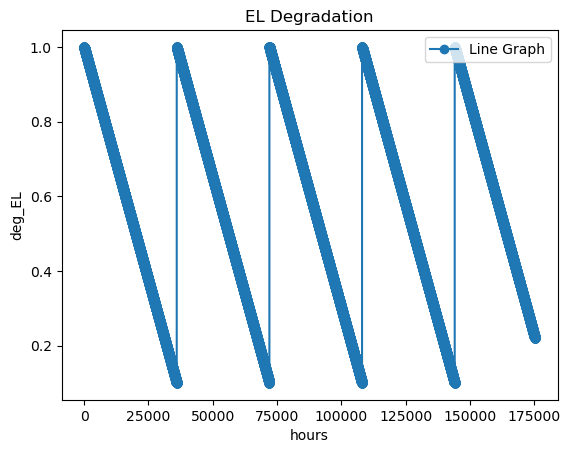

In [5]:
# Create a figure and axis
fig, ax = plt.subplots()
ax.plot(n,deg_EL, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('deg_EL')
ax.set_title('EL Degradation')

# Add a legend
ax.legend()

# Display the plot
plt.show()

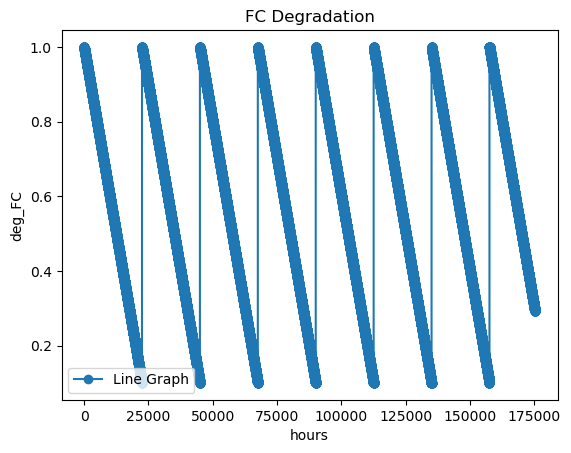

In [6]:
# Create a figure and axis
fig, ax = plt.subplots()
ax.plot(n,deg_FC, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('deg_FC')
ax.set_title('FC Degradation')

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [7]:
### Variables

E_H2_prod= gppd.add_vars(m, i, name="E_H2_prod", vtype=GRB.CONTINUOUS) #hydrogen prodcution

E_grid_to_EL= gppd.add_vars(m, i, name="E_grid_to_EL", vtype=GRB.CONTINUOUS) #electricity from grid to EL
E_comp= gppd.add_vars(m, i, name="E_comp", vtype=GRB.CONTINUOUS) #electricity consumption from compressor
E_FC_to_grid= gppd.add_vars(m, i, name="E_FC_to_grid", vtype=GRB.CONTINUOUS) #electricity from FC to grid
E_H2_cons= gppd.add_vars(m, i, name="E_H2_cons", vtype=GRB.CONTINUOUS) #hydrogen consumption
E_tank= gppd.add_vars(m, i, name="E_tank", vtype=GRB.CONTINUOUS) #tank content
A_EL = gppd.add_vars(m, i, name="A_EL", vtype=GRB.BINARY) #EL activation
A_FC = gppd.add_vars(m, i, name="A_FC", vtype=GRB.BINARY) #FC activation


A_FC_sm = gppd.add_vars(m, i, name="A_FC_sm", vtype=GRB.BINARY) #participation 
A_EL_sm = gppd.add_vars(m, i, name="A_EL_sm", vtype=GRB.BINARY) #participation 


A_FC_up = gppd.add_vars(m, i, name="A_FC_up", vtype=GRB.BINARY) #participation 
A_EL_up = gppd.add_vars(m, i, name="A_EL_up", vtype=GRB.BINARY) #participation 

A_FC_down = gppd.add_vars(m, i, name="A_FC_down", vtype=GRB.BINARY) #participation 
A_EL_down= gppd.add_vars(m, i, name="A_EL_down", vtype=GRB.BINARY) #participation 


E_FC_sm= gppd.add_vars(m, i,lb=0, name="E_FC_sm", vtype=GRB.CONTINUOUS) #FC to grid spot market
E_EL_sm= gppd.add_vars(m, i, lb=0, name="E_EL_sm", vtype=GRB.CONTINUOUS) # EL to grid spot market

E_FC_up= gppd.add_vars(m, i, name="E_FC_up", vtype=GRB.CONTINUOUS) #FC to grid up
E_EL_up= gppd.add_vars(m, i, name="E_EL_up", vtype=GRB.CONTINUOUS) # EL to grid up

E_FC_down= gppd.add_vars(m, i, name="E_FC_down", vtype=GRB.CONTINUOUS) #FC to grid down
E_EL_down= gppd.add_vars(m, i, name="E_EL_down", vtype=GRB.CONTINUOUS) # EL to grid down

P_up= gppd.add_vars(m, i, name="P_up", vtype=GRB.CONTINUOUS) # Up reg provided to the grid
P_down= gppd.add_vars(m, i, name="P_down", vtype=GRB.CONTINUOUS) # Down provided to the grid
E_SM_sell= gppd.add_vars(m, i, name="E_SM_sell", vtype=GRB.CONTINUOUS) # Energy sold to the grid
E_SM_pur= gppd.add_vars(m, i, name="E_SM_pur", vtype=GRB.CONTINUOUS) # Energy purchased from the grid
E_SM_pur= gppd.add_vars(m, i, name="E_SM_pur", vtype=GRB.CONTINUOUS) # Energy purchased from the grid


### 3. Constraints 

In [8]:
### Energy Balances

const1 = gppd.add_constrs(m,E_H2_prod, GRB.EQUAL, ( E_grid_to_EL - E_comp)*EL_eff, name="H2_prod") # Hydrogen production
m.update()
const2 = gppd.add_constrs(m,E_FC_to_grid, GRB.EQUAL, E_H2_cons*FC_eff, name="H2_cons") # Hydrogen consumption
m.update()
constr3 = gppd.add_constrs(m,E_H2_cons, GRB.LESS_EQUAL, E_tank, name="H2_cons_max") # Hydrogen consumption max
m.update()
const4 = gppd.add_constrs(m,E_comp, GRB.EQUAL, (E_H2_prod/LHVh2)*wcomp, name="Comp_con") # Hydrogen consumption
m.update()
    
m.addConstr(E_tank[0] == 0.9*tank_cap) # Initial tank content 
m.update()

print ("energy balance check")

### Activation Constraints
const5 = gppd.add_constrs(m,A_EL*eEL*EL_cap, GRB.LESS_EQUAL, E_grid_to_EL  - E_comp, name="min_EL_load") # Minimum EL load
m.update()
const6 = gppd.add_constrs(m,E_grid_to_EL  - E_comp, GRB.LESS_EQUAL, A_EL*EL_cap*cfEL*deg_EL , name="max_EL_load") # Maximum EL load
m.update()
const7 = gppd.add_constrs(m,A_FC*eFC*FC_cap, GRB.LESS_EQUAL, E_FC_to_grid, name="min_FC_load") # Minimum FC load
m.update()
const8 = gppd.add_constrs(m,E_FC_to_grid, GRB.LESS_EQUAL, A_FC*FC_cap*cfFC*deg_FC , name="max_FC_load") # Maximum FC load
m.update()
const9 = gppd.add_constrs(m,E_tank, GRB.LESS_EQUAL, tank_cap , name="tank_max") # Maximum tank content
m.update()
print ("activation check")

### Services to the grid
const10 = gppd.add_constrs(m,E_FC_to_grid, GRB.EQUAL, E_FC_sm , name="FC_to_Grid") # FC grid services
m.update()

const12 = gppd.add_constrs(m,E_grid_to_EL, GRB.EQUAL, E_EL_sm, name="Grid_to_EL") # FC grid services
m.update()
print ("services check")

### Minimum bid
const13 = gppd.add_constrs(m,E_EL_down, GRB.GREATER_EQUAL, 0.1*A_EL_down, name="Grid_to_EL") # Minimum bid
m.update()

const14 = gppd.add_constrs(m,E_EL_down, GRB.LESS_EQUAL, M*A_EL_down, name="Grid_to_EL") # Minimum bid
m.update()

const15 = gppd.add_constrs(m,E_FC_down, GRB.GREATER_EQUAL, 0.1*A_FC_down, name="Grid_to_EL") # Minimum bid
m.update()
const16 = gppd.add_constrs(m,E_FC_down, GRB.LESS_EQUAL, M*A_FC_down, name="Grid_to_EL") # Minimum bid
m.update()


const19 = gppd.add_constrs(m,E_EL_up, GRB.GREATER_EQUAL, 0.1*A_EL_up, name="Grid_to_EL") # Minimum bid
m.update()
const20 = gppd.add_constrs(m,E_EL_up, GRB.LESS_EQUAL, M*A_EL_up, name="Grid_to_EL") # Minimum bid
m.update()

const21 = gppd.add_constrs(m,E_FC_up, GRB.GREATER_EQUAL, 0.1*A_FC_up, name="Grid_to_EL") # Minimum bid
m.update()
const22 = gppd.add_constrs(m,E_FC_up, GRB.LESS_EQUAL, M*A_FC_up, name="Grid_to_EL") # Minimum bid
m.update()


const25 = gppd.add_constrs(m,E_EL_sm, GRB.GREATER_EQUAL, 0.1*A_EL_sm, name="Grid_to_EL") # Minimum bid
m.update()
const26 = gppd.add_constrs(m,E_EL_sm, GRB.LESS_EQUAL, M*A_EL_sm, name="Grid_to_EL") # Minimum bid
m.update()

const27 = gppd.add_constrs(m,E_FC_sm, GRB.GREATER_EQUAL, 0.1*A_FC_sm, name="Grid_to_EL") # Minimum bid
m.update()
const28 = gppd.add_constrs(m,E_FC_sm, GRB.LESS_EQUAL, M*A_FC_sm, name="Grid_to_EL") # Minimum bid
m.update()



print ("minimum bid check")

### Power availability 
const31 = gppd.add_constrs(m,P_up, GRB.EQUAL, E_EL_up + E_FC_up  , name="up_reg") # up grid services
m.update()

const32 = gppd.add_constrs(m,P_down, GRB.EQUAL, E_EL_down + E_FC_down  , name="up_reg") # up grid services
m.update()

const33 = gppd.add_constrs(m,E_FC_down, GRB.LESS_EQUAL, E_FC_sm, name="FC_down_max") #Max FC down reg
m.update()

const34 = gppd.add_constrs(m,E_FC_up, GRB.LESS_EQUAL, FC_cap*cfFC*deg_FC-E_FC_sm, name="FC_up_max") # Max FC up reg
m.update()

const35 = gppd.add_constrs(m,E_EL_up, GRB.LESS_EQUAL, E_EL_sm, name="EL_up_max") #Max EL up reg
m.update()

const36 = gppd.add_constrs(m,E_EL_down, GRB.LESS_EQUAL, EL_cap*cfEL*deg_EL-E_EL_sm, name="EL_down_max") # Max EL down reg
m.update()



print ("power availability check")

### Spot Market
const39 = gppd.add_constrs(m,E_SM_sell, GRB.EQUAL,E_FC_sm , name="SM_sell") # Energy sold in the sport market
m.update()

const40 = gppd.add_constrs(m,E_SM_pur, GRB.EQUAL,E_EL_sm , name="SM_pur") # energy purchased in the spot market
m.update()

print ("spot market check")



energy balance check
activation check
services check
minimum bid check
power availability check
spot market check


In [9]:
# Get all the constraints from the model
all_constraints = m.getConstrs()
len(all_constraints)

5431201

In [10]:
### Hydrogen content in the tank
indices = list(range(len(n) - 1))

# Create a list of expressions for the constraint
[m.addConstr(E_tank[j+1] == E_tank[j]*(1-etank) + E_H2_prod[j] - E_H2_cons[j]) for j in indices]
m.update()
        
print ("hydrogen content check")

hydrogen content check


In [11]:
# Get all the constraints from the model
all_constraints = m.getConstrs()
len(all_constraints)


5606400

### 4. Objective function

In [12]:
revenue = gp.LinExpr()

revenue = -1*Inv_costs

for k in i:
    revenue+= 0.9*P_up[k]*up_prices[k] + 0.9*P_down[k]*down_prices[k] + E_SM_sell[k]*SM_prices_sell[k] - E_SM_pur[k]*SM_prices_pur[k]

m.setObjective(revenue, GRB.MAXIMIZE)

### 5. Optimize model

In [13]:
m.setParam('TimeLimit', 300)
m.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to catarina.isabel.novais.da.luz@estudiantat.upc.edu
Optimize a model with 5606400 rows, 4380000 columns and 12263997 nonzeros
Model fingerprint: 0xdc035450
Variable types: 2978400 continuous, 1401600 integer (1401600 binary)
Coefficient statistics:
  Matrix range     [7e-03, 1e+07]
  Objective range  [4e-03, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 2e+01]
Presolve removed 1899479 rows and 1849792 columns (presolve time = 5s) ...
Presolve removed 1900256 rows and 1850569 columns (presolve time = 10s) ...
Presolve removed 2238623 rows and 2188936 columns (presolve time = 15s) ...
Presolve removed 2576801 rows and 2189132 columns (presolve time = 21s) ...
Presolve removed 2576809 rows and 2189138 columns

### 6. Results Visualization

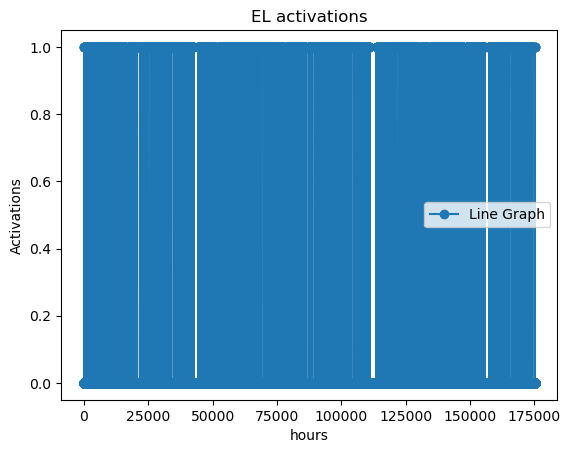

In [14]:
#EL Activations
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
EL_Act = m.getAttr('X', A_EL)
ax.plot(n,EL_Act, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Activations')
ax.set_title('EL activations')

# Add a legend
ax.legend()

# Display the plot
plt.show()

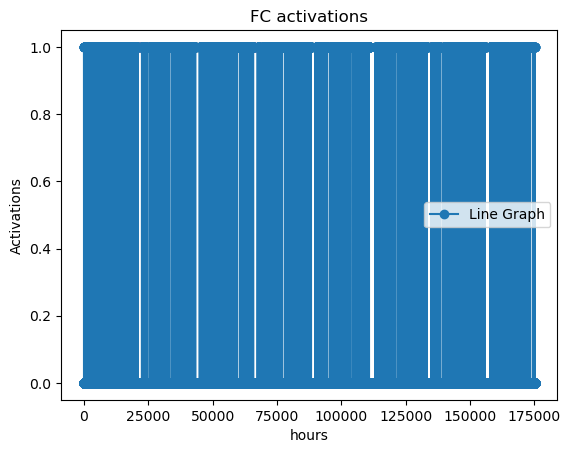

In [15]:
#FC Activations
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
FC_Act = m.getAttr('X', A_FC)
ax.plot(n,FC_Act, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Activations')
ax.set_title('FC activations')

# Add a legend
ax.legend()

# Display the plot
plt.show()

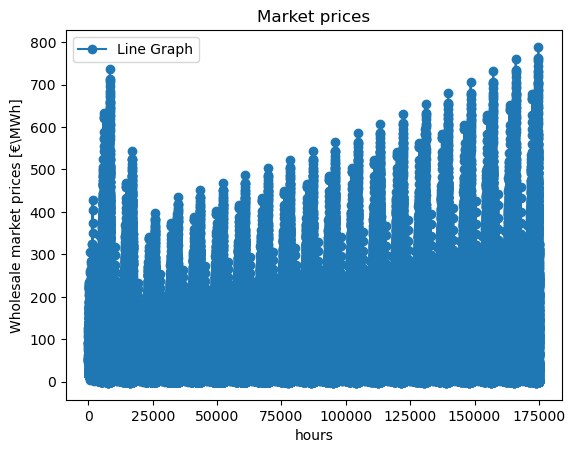

In [16]:
# Prices
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
ax.plot(n, SM_prices_pur, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Wholesale market prices [€\MWh]')
ax.set_title('Market prices')

# Add a legend
ax.legend()

# Display the plot
plt.show()

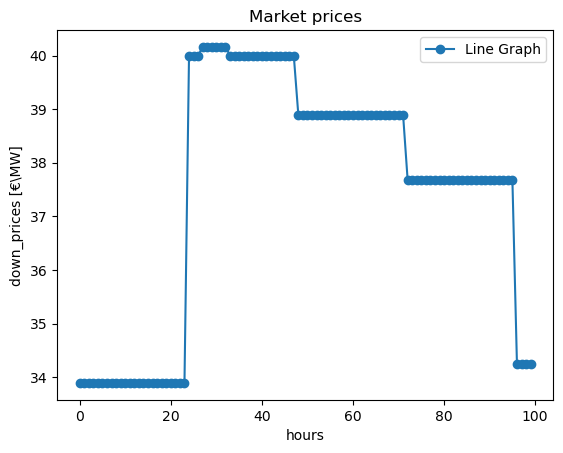

In [17]:
# Prices
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
ax.plot(n[:100], down_prices[:100], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('down_prices [€\MW]')
ax.set_title('Market prices')

# Add a legend
ax.legend()

# Display the plot
plt.show()

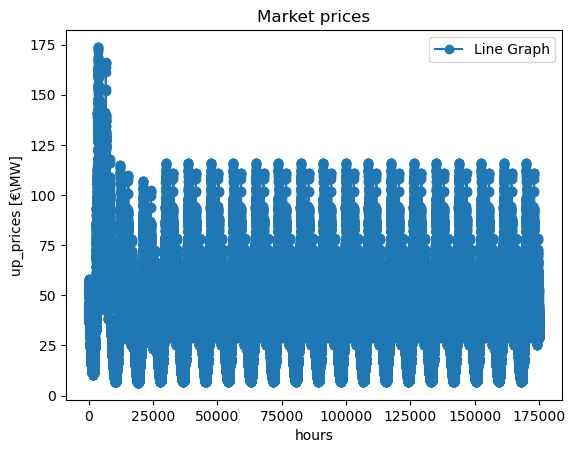

In [18]:
# Prices
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
ax.plot(n, up_prices, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('up_prices [€\MW]')
ax.set_title('Market prices') 

# Add a legend
ax.legend()

# Display the plot
plt.show()

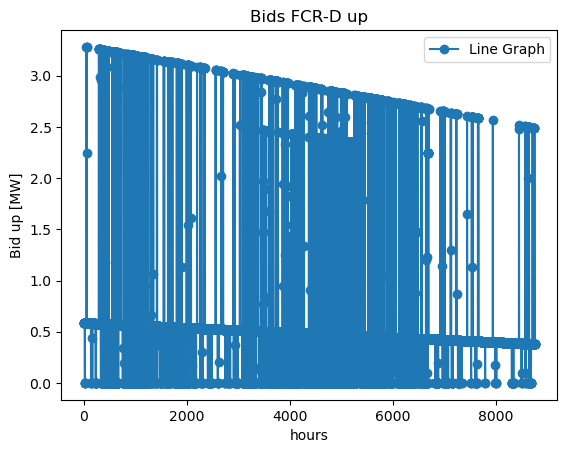

3.280545899999992

In [19]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
P_up_values = m.getAttr('X', P_up)
ax.plot(n[:8760],P_up_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Bid up [MW]')
ax.set_title('Bids FCR-D up')

# Add a legend
ax.legend()

# Display the plot
plt.show()
max(P_up_values)

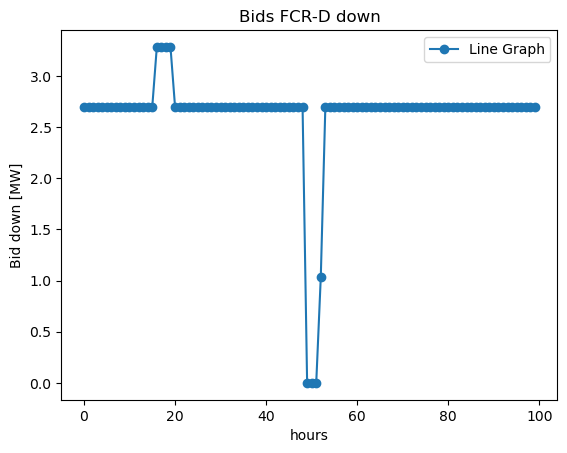

In [20]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
P_down_values = m.getAttr('X', P_down)
ax.plot(n[:100],P_down_values[:100], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Bid down [MW]')
ax.set_title('Bids FCR-D down')

# Add a legend
ax.legend()

# Display the plot
plt.show()

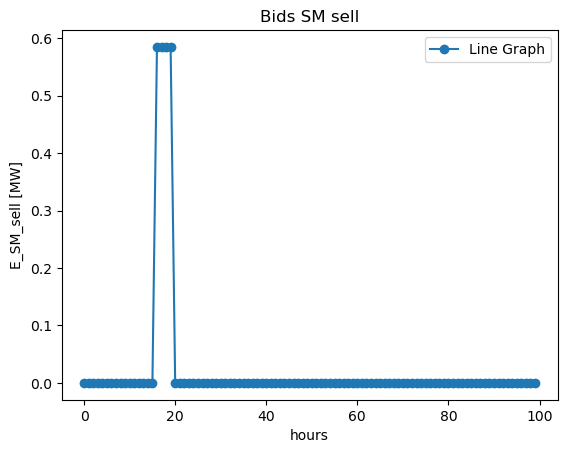

In [21]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_SM_sell_values = m.getAttr('X', E_SM_sell)
ax.plot(n[:100],E_SM_sell_values[:100], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('E_SM_sell [MW]')
ax.set_title('Bids SM sell')

# Add a legend
ax.legend()

# Display the plot
plt.show()

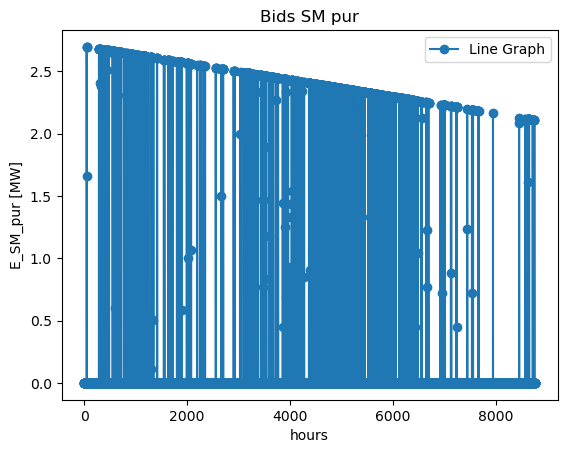

In [22]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_SM_pur_values = m.getAttr('X', E_SM_pur)
ax.plot(n[:8760],E_SM_pur_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('E_SM_pur [MW]')
ax.set_title('Bids SM pur')

# Add a legend
ax.legend()

# Display the plot
plt.show()

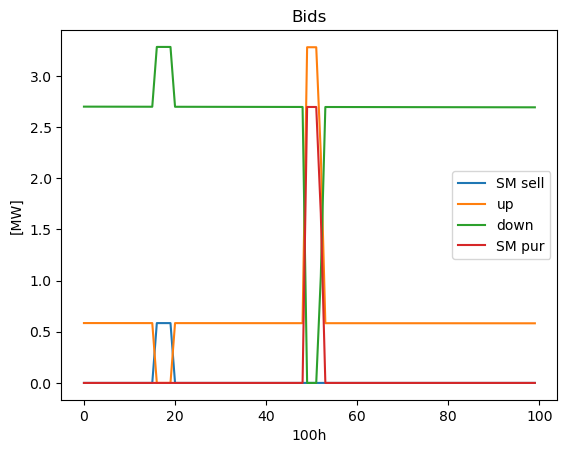

In [23]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines
ax.plot(n[:100], E_SM_sell_values[:100], label='SM sell')
ax.plot(n[:100], P_up_values[:100], label='up')
ax.plot(n[:100], P_down_values[:100], label='down')
ax.plot(n[:100], E_SM_pur_values[:100], label='SM pur')

# Set title and labels
ax.set_title('Bids')
ax.set_xlabel('100h')
ax.set_ylabel('[MW]')

# Add a legend
ax.legend()

# Show the plot
plt.show()

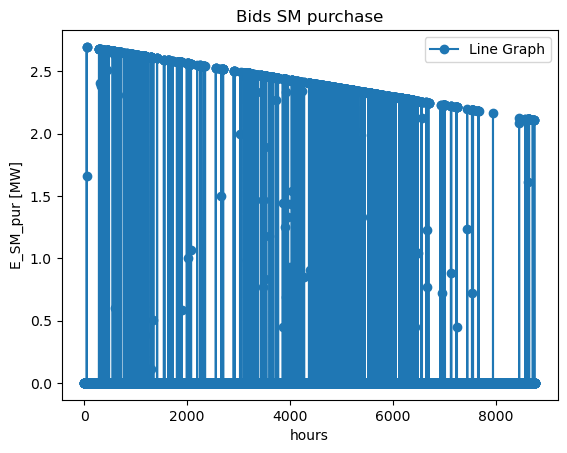

In [24]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_SM_pur_values = m.getAttr('X', E_SM_pur)
ax.plot(n[:8760],E_SM_pur_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('E_SM_pur [MW]')
ax.set_title('Bids SM purchase')

# Add a legend
ax.legend()

# Display the plot
plt.show()


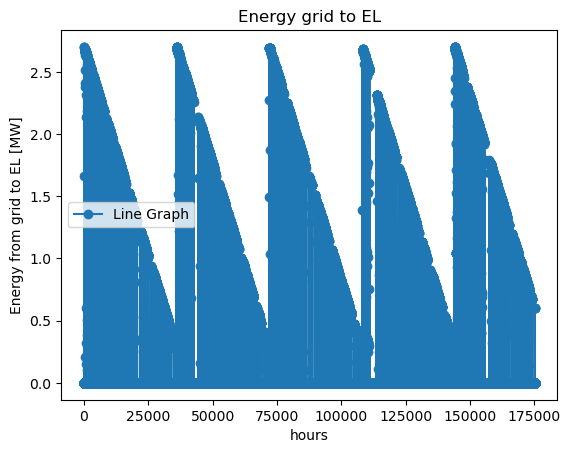

In [25]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_grid_to_EL_values = m.getAttr('X', E_grid_to_EL)
ax.plot(n,E_grid_to_EL_values, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Energy from grid to EL [MW]')
ax.set_title('Energy grid to EL')

# Add a legend
ax.legend()

# Display the plot
plt.show()

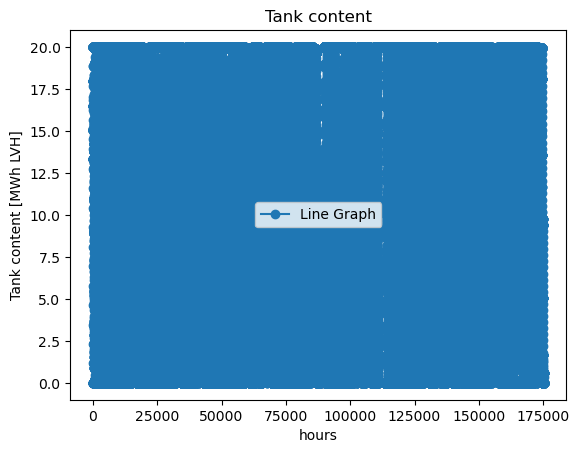

0.0

In [26]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_tank_values = m.getAttr('X', E_tank)
ax.plot(n,E_tank_values, marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('Tank content [MWh LVH]')
ax.set_title('Tank content')

# Add a legend
ax.legend()

# Display the plot
plt.show()
E_tank_values[years*8760-1]

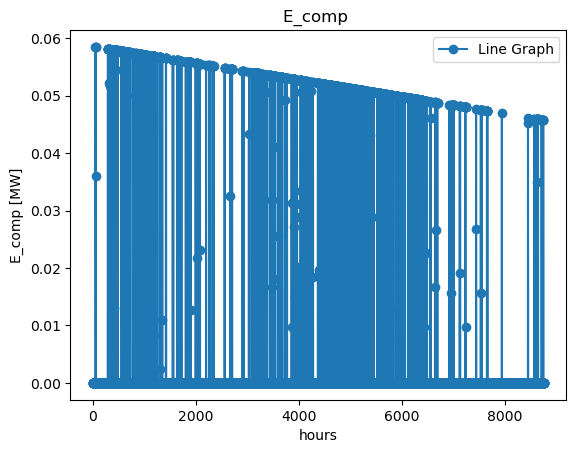

In [27]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_comp_values = m.getAttr('X', E_comp)
ax.plot(n[:8760],E_comp_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('E_comp [MW]')
ax.set_title('E_comp ')

# Add a legend
ax.legend()

# Display the plot
plt.show()

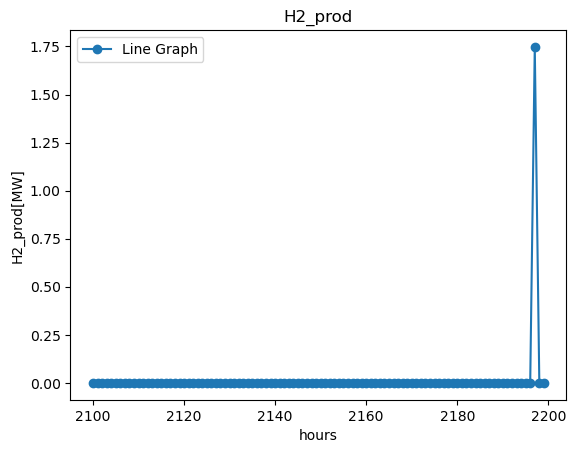

In [28]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
H2_prod_values = m.getAttr('X', E_H2_prod)
ax.plot(n[2100:2200],H2_prod_values[2100:2200], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('H2_prod[MW]')
ax.set_title('H2_prod')

# Add a legend
ax.legend()

# Display the plot
plt.show()

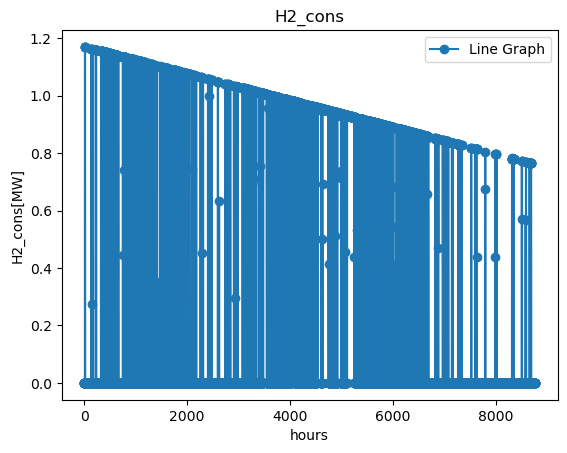

In [29]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
H2_cons_values = m.getAttr('X', E_H2_cons)
ax.plot(n[:8760],H2_cons_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('H2_cons[MW]')
ax.set_title('H2_cons')

# Add a legend
ax.legend()

# Display the plot
plt.show()

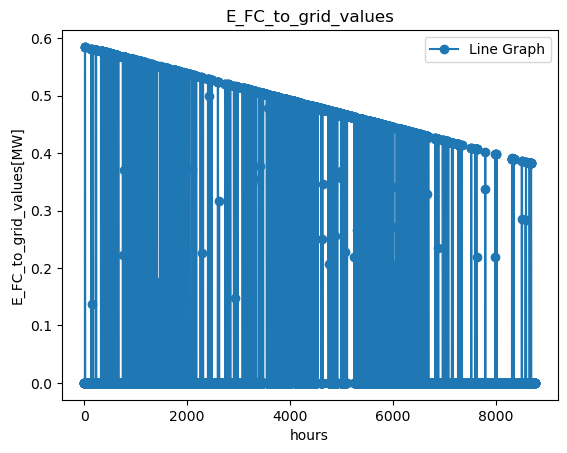

In [30]:
#P_up 
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_FC_to_grid_values = m.getAttr('X', E_FC_to_grid)
ax.plot(n[:8760],E_FC_to_grid_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('E_FC_to_grid_values[MW]')
ax.set_title('E_FC_to_grid_values')

# Add a legend
ax.legend()

# Display the plot
plt.show()

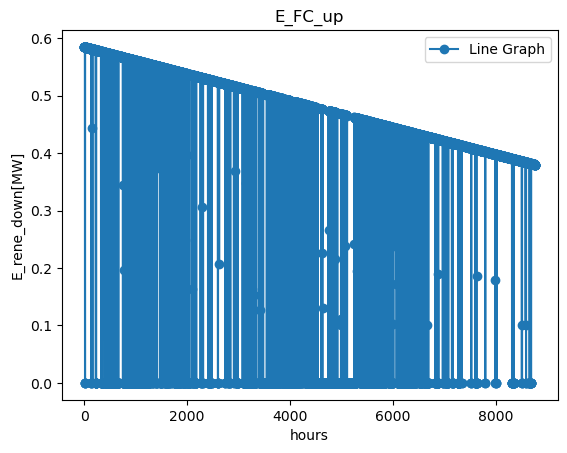

In [31]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line graph
E_FC_up_values = m.getAttr('X', E_FC_up)
ax.plot(n[:8760],E_FC_up_values[:8760], marker='o', linestyle='-', label='Line Graph')

# Set labels and title
ax.set_xlabel('hours')
ax.set_ylabel('E_rene_down[MW]')
ax.set_title('E_FC_up')

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [32]:
### Shutdowns
shut_EL=0
shut_FC=0
for k in range (len(n)-1):
    if EL_Act[k]==1 and EL_Act[k+1]==0:
        shut_EL +=1
    if FC_Act[k]==1 and FC_Act[k+1]==0:
        shut_FC +=1

### Operating hours        
oper_EL = sum (EL_Act) 
oper_FC = sum (FC_Act)

print ("EL shutdowns:",shut_EL)
print ("FC shutdowns:", shut_FC)
print ("Operation hours EL:", oper_EL/1000)
print ("Operation hours FC:",oper_FC/1000)

EL shutdowns: 3943
FC shutdowns: 5229
Operation hours EL: 19.955
Operation hours FC: 31.674


In [33]:
### Kg of H2 produced 

Total_H2_prod=((sum(H2_prod_values)*3600)/LHVh2)
print ("Total H2 produced [t]:", Total_H2_prod/1000)

Total H2 produced [t]: 575.0772408749085


In [34]:
### Overall system efficiency in 20 years \beg
system_eff = (sum(E_FC_to_grid_values))/( + E_tank_values[0] - E_tank_values[years*8760-1] + sum (E_grid_to_EL_values))
print ("System efficiency:", system_eff)

System efficiency: 0.34251118656845786


In [35]:
# Calculate the total energy generated MWh
total_energy_generated = +sum(E_FC_to_grid_values)
print(total_energy_generated)

9593.62068124851


In [36]:
# Total energy per year
energy_gen_array=np.zeros(years*8760)
for k in range(years*8760):
    energy_gen_array[k]=E_FC_to_grid_values[k]

energy_gen_array_year= np.array(energy_gen_array).reshape((years, 8760)).sum(axis=1)



In [37]:
### System losses
system_losses = + E_tank_values[0] - E_tank_values[years*8760-1]- sum (E_grid_to_EL_values) +sum(E_FC_to_grid_values)
print ("System losses [MWh]:",system_losses)



System losses [MWh]: -18380.03581308333


In [38]:
### P2P Efficiency
P2P_losses =(sum(E_FC_to_grid_values) + E_tank_values[years*8760-1])/(E_tank_values[0]+sum(E_grid_to_EL_values))
print (P2P_losses)


0.34251118656845786


In [39]:
### Energy reserved for up and down

print ("Energy reserved for up [GWh]:", sum(P_up_values)/1000)
print ("Energy reserved for down [GWh]:", sum(P_down_values)/1000)

Energy reserved for up [GWh]: 74.77337151203308
Energy reserved for down [GWh]: 246.82197386317236


In [40]:
print ("Energy sold in SM [GWh]:", sum(E_SM_sell_values)/1000)
print ("Energy purchased from [GWh]:", sum(E_SM_pur_values)/1000)

Energy sold in SM [GWh]: 9.593620681248511
Energy purchased from [GWh]: 27.991656494331842


In [41]:
### values to inpu tin Excel

E_EL_up_values = m.getAttr('X', E_EL_up)
annual_E_EL_up_values=np.sum(np.array(E_EL_up_values).reshape(years, 8760), axis=1) 

E_FC_up_values = m.getAttr('X', E_FC_up)
annual_E_FC_up_values=np.sum(np.array(E_FC_up_values).reshape(years, 8760), axis=1) 



E_EL_down_values = m.getAttr('X', E_EL_down)
annual_E_EL_down_values=np.sum(np.array(E_EL_down_values).reshape(years, 8760), axis=1) 

E_FC_down_values = m.getAttr('X', E_FC_down)
annual_E_FC_down_values=np.sum(np.array(E_FC_down_values).reshape(years, 8760), axis=1) 


E_EL_sm_values = m.getAttr('X', E_EL_sm)
annual_E_EL_sm_values=np.sum(np.array(E_EL_sm_values).reshape(years, 8760), axis=1) 


E_FC_sm_values = m.getAttr('X', E_FC_sm)
annual_E_FC_sm_values=np.sum(np.array(E_FC_sm_values).reshape(years, 8760), axis=1) 

In [42]:
discount_rate = 0.05
revenue_array=np.zeros(years*8760)
cash_flows_in=np.zeros(years+1)


R_up_FC=np.zeros(years*8760)
annual_R_up_FC=np.zeros(years+1)

R_up_EL=np.zeros(years*8760)
annual_R_up_EL=np.zeros(years+1)




R_down_FC=np.zeros(years*8760)
annual_R_down_FC=np.zeros(years)

R_down_EL=np.zeros(years*8760)
annual_R_down_EL=np.zeros(years)



R_sm_FC=np.zeros(years*8760)
annual_R_sm_FC=np.zeros(years)

R_sm_EL=np.zeros(years*8760)
annual_R_sm_EL=np.zeros(years)



total_rev=0
ac_profit=0


for k in range(years*8760):
    if k>0:
        revenue_array[k]=0.9*P_up_values[k]*up_prices[k] + 0.9*P_down_values[k]*down_prices[k] + E_SM_sell_values[k]*SM_prices_sell[k] - E_SM_pur_values[k]*SM_prices_pur[k]
        
   
        R_up_EL[k]=E_EL_up_values[k]*up_prices[k]*0.9
        R_up_FC[k]=E_FC_up_values[k]*up_prices[k]*0.9


        R_down_EL[k]=E_EL_down_values[k]*down_prices[k]*0.9
        R_down_FC[k]=E_FC_down_values[k]*down_prices[k]*0.9

    
        R_sm_EL[k]=E_EL_sm_values[k]*SM_prices_pur[k]
        R_sm_FC[k]=E_FC_sm_values[k]*SM_prices_sell[k]
        
        
        

initial_investment = ( FC_capex*FC_cap + EL_capex*EL_cap + comp_capex*comp_cap + tank_capex*tank_cap)*1000 # 160 million euros
cash_flows_in[0] = -initial_investment

Annual_opex = (( + FC_capex*FC_cap*(FC_opex)+ EL_capex*EL_cap*(EL_opex) + comp_capex*comp_cap*(comp_opex) + tank_capex*tank_cap*(tank_opex))*1000)/20

total_repex = (FC_capex*FC_cap*FC_repex*7 + EL_capex*EL_cap*EL_repex*4)*1000

discount_opex = np.zeros(years)
discount_repex = np.zeros(years)
energy_gen_year_dis = np.zeros(years)

for k in range(years):
    energy_gen_year_dis[k]=energy_gen_array_year[k]/((1+discount_rate)**k)

for i in range(years):
    discount_opex[i] = Annual_opex / ((1 + discount_rate)**i)
    

# Calculate the discounted cash flows
cash_flows = np.array(revenue_array).reshape((years, 8760)).sum(axis=1)



annual_R_up_EL = np.sum(np.array(R_up_EL).reshape(years, 8760), axis=1) / (1 + discount_rate) ** np.arange(years)
annual_R_up_FC = np.sum(np.array(R_up_FC).reshape(years, 8760), axis=1) / (1 + discount_rate) ** np.arange(years)

annual_R_down_EL = np.sum(np.array(R_down_EL).reshape(years, 8760), axis=1) / (1 + discount_rate) ** np.arange(years)
annual_R_down_FC = np.sum(np.array(R_down_FC).reshape(years, 8760), axis=1) / (1 + discount_rate) ** np.arange(years)

annual_R_sm_EL = np.sum(np.array(R_sm_EL).reshape(years, 8760), axis=1) / (1 + discount_rate) ** np.arange(years)
annual_R_sm_FC = np.sum(np.array(R_sm_FC).reshape(years, 8760), axis=1) / (1 + discount_rate) ** np.arange(years)
                        

cash_flows = cash_flows - Annual_opex



cash_flows[2]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[2] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**3)

cash_flows[4]-= EL_capex*EL_cap*EL_repex*1000
discount_repex[4] = EL_capex*EL_cap*EL_repex*1000 / ((1 + discount_rate)**5)

cash_flows[5]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[5] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**6)

cash_flows[7]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[7] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**8)

cash_flows[8]-= EL_capex*EL_cap*EL_repex*1000
discount_repex[8] = EL_capex*EL_cap*EL_repex*1000 / ((1 + discount_rate)**9)

cash_flows[10]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[10] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**11)

cash_flows[12]-= EL_capex*EL_cap*EL_repex*1000
discount_repex[12] = EL_capex*EL_cap*EL_repex*1000 / ((1 + discount_rate)**13)

cash_flows[12]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[12] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**13)

cash_flows[15]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[15] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**16)

cash_flows[16]-= EL_capex*EL_cap*EL_repex*1000
discount_repex[16] = EL_capex*EL_cap*EL_repex*1000 / ((1 + discount_rate)**17)

cash_flows[17]-= FC_capex*FC_cap*FC_repex*1000
discount_repex[17] = FC_capex*FC_cap*FC_repex*1000 / ((1 + discount_rate)**18)

cash_flows_in[1:years+1] =cash_flows 

discounted_cash_flows = cash_flows_in / (1 + discount_rate) ** np.arange(0, years+1)

## IRR
irr = npf.irr(cash_flows_in)

## NPV
npv= sum (discounted_cash_flows)
# ROI
roi = ((sum(discounted_cash_flows)) / (initial_investment)) * 100

# Calculate the Payback Period
cumulative_cash_flows = np.cumsum(discounted_cash_flows)
payback_period = np.argmax(cumulative_cash_flows + initial_investment >= initial_investment) + 1

# Calculate the Levelized Cost of Electricity (LCOE)
lcoe = (sum(discount_opex)+ sum(discount_repex) + initial_investment) / (sum(energy_gen_year_dis))

print("Initial Investment [M EUR]:", initial_investment/(1000))
print("ROI [%]:", roi)
print("Payback Period (in years):", payback_period)
print ("Total Revenue (M EUR):", sum(revenue_array))
print("LCOE (EUR/MWh):", lcoe)
print("IRR [-]:", irr)
print("NPV [k EUR]:", npv/(1000))

Initial Investment [M EUR]: 6426.0
ROI [%]: -55.80855846931585
Payback Period (in years): 1
Total Revenue (M EUR): 13671918.016885066
LCOE (EUR/MWh): 1722.9327867571378
IRR [-]: -0.038954762992569836
NPV [k EUR]: -3586.2579672382362


**Input Annual values in Excel**

In [43]:
subset_size = 8760  # size of each subset
num_subsets = int(np.ceil(len(E_grid_to_EL_values) / subset_size))  # calculate the number of subsets
annual_E_grid_to_EL_values=np.zeros(years)

for i in range(num_subsets):
    start_index = i * subset_size  # calculate the start index of the current subset
    end_index = min((i + 1) * subset_size, len(E_grid_to_EL_values))  # calculate the end index of the current subset

    subset = E_grid_to_EL_values[start_index:end_index]  # extract the current subset of data
    subset_sum = np.sum(subset)  # calculate the sum of the current subset

    # Save the subset sum or perform any other operations as needed
    annual_E_grid_to_EL_values[i]=subset_sum

In [44]:
subset_size = 8760  # size of each subset
num_subsets = int(np.ceil(len(E_FC_to_grid_values) / subset_size))  # calculate the number of subsets
annual_E_FC_to_grid_values=np.zeros(years)

for i in range(num_subsets):
    start_index = i * subset_size  # calculate the start index of the current subset
    end_index = min((i + 1) * subset_size, len(E_FC_to_grid_values))  # calculate the end index of the current subset

    subset = E_FC_to_grid_values[start_index:end_index]  # extract the current subset of data
    subset_sum = np.sum(subset)  # calculate the sum of the current subset

    # Save the subset sum or perform any other operations as needed
    annual_E_FC_to_grid_values[i]=subset_sum

In [45]:
subset_size = 8760  # size of each subset
num_subsets = int(np.ceil(len(E_tank_values) / subset_size))  # calculate the number of subsets
annual_E_tank_values=np.zeros(years)

for i in range(num_subsets):
    start_index = i * subset_size  # calculate the start index of the current subset
    end_index = min((i + 1) * subset_size, len(E_tank_values))  # calculate the end index of the current subset

    subset = E_tank_values[start_index:end_index]  # extract the current subset of data
    subset_sum = np.sum(subset)  # calculate the sum of the current subset

    # Save the subset sum or perform any other operations as needed
    annual_E_tank_values[i]=subset_sum

In [46]:
subset_size = 8760  # size of each subset
num_subsets = int(np.ceil(len(E_FC_up_values) / subset_size))  # calculate the number of subsets



for i in range(num_subsets):
    start_index = i * subset_size  # calculate the start index of the current subset
    end_index = min((i + 1) * subset_size, len(E_FC_up_values))  # calculate the end index of the current subset

    subset_2 = E_EL_up_values[start_index:end_index]  # extract the current subset of data
    subset_sum_2 = np.sum(subset_2)  # calculate the sum of the current subset
    subset_3 = E_FC_up_values[start_index:end_index]  # extract the current subset of data
    subset_sum_3 = np.sum(subset_3)  # calculate the sum of the current subset
    


    subset_5 = E_EL_down_values[start_index:end_index]  # extract the current subset of data
    subset_sum_5 = np.sum(subset_5)  # calculate the sum of the current subset
    subset_6 = E_FC_down_values[start_index:end_index]  # extract the current subset of data
    subset_sum_6 = np.sum(subset_6)  # calculate the sum of the current subset
    
    
  

    subset_8 = E_EL_sm_values[start_index:end_index]  # extract the current subset of data
    subset_sum_8 = np.sum(subset_8)  # calculate the sum of the current subset
    subset_9 = E_FC_sm_values[start_index:end_index]  # extract the current subset of data
    subset_sum_9 = np.sum(subset_9)  # calculate the sum of the current subset
    

In [47]:
workbook = openpyxl.Workbook()
worksheet = workbook.active

for col, values in enumerate([ annual_E_grid_to_EL_values, annual_E_FC_to_grid_values, annual_E_tank_values,  annual_E_EL_up_values, annual_E_FC_up_values,  annual_E_EL_down_values, annual_E_FC_down_values,  annual_E_EL_sm_values, annual_E_FC_sm_values,  annual_R_up_EL, annual_R_up_FC,  annual_R_down_EL, annual_R_down_FC,  annual_R_sm_EL, annual_R_sm_FC, discount_opex, discount_repex], start=1):
   
    for row, value in enumerate(values, start=1):
        worksheet.cell(row=row, column=col, value=value)

worksheet.cell(row=1, column=col+1, value=initial_investment)
# Save the workbook to a file
workbook.save('NO_RENE_WITH_FREQ_3.xlsx')